In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy import signal
import scipy
import seaborn as sns

# Acquisizione Dati dal file

In [101]:
file_name = "center_sternum.txt"
raw_data = pd.read_csv(file_name, sep="\t")

# Togliamo le colonne che non ci servono
raw_data = raw_data.drop(["Log Mode", "qw", "qi", "qj", "qk"], axis=1)

# Controlliamo che ci sia solo una frequenza unica in tutto il file
if len(raw_data["Log Freq"].unique()) != 1:
    print("Ci sono diverse frequenze di acquisizione nello stesso file")
    exit(1)

# Prendiamo la frequenza
ACQ_FREQ = raw_data.loc[0, "Log Freq"] #type: int

# Creiamo la colonna tempo assoluto andando a multipli del timestep
raw_data.insert(2, "Abs Time", np.arange(0, len(raw_data)) * (1 / ACQ_FREQ), allow_duplicates=False)

raw_data


,Log Freq,Timestamp,Abs Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,200,1576222772,0.000,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178
1,200,1576222772,0.005,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177
2,200,1576222772,0.010,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177
3,200,1576222772,0.015,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176
4,200,1576222772,0.020,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176
...,...,...,...,...,...,...,...,...,...,...,...,...
16501,200,1576222847,82.505,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126
16502,200,1576222847,82.510,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125
16503,200,1576222847,82.515,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125
16504,200,1576222847,82.520,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124


In [102]:
offset_gyro = np.array([-2.242224, 2.963463, -0.718397])
calibration_acc = np.array([[1.000966, -0.002326418, -0.0006995499],
                            [-0.002326379, 0.9787045, -0.001540918],
                            [-0.0006995811, -0.001540928, 1.00403]])
offset_acc = np.array([-3.929942, -13.74679, 60.67546])
calibration_magn = np.array([[0.9192851, -0.02325168, 0.003480837],
                             [-0.02325175, 0.914876, 0.004257396],
                             [0.003481006, 0.004257583, 0.8748001]])
offset_magn = np.array([-95.67974, -244.9142, 17.71132])

raw_data[['AccX', 'AccY', 'AccZ']] = np.dot(raw_data[['AccX', 'AccY', 'AccZ']], calibration_acc.T) + offset_acc.T
raw_data[['GyroX', 'GyroY', 'GyroZ']] = raw_data[['GyroX', 'GyroY', 'GyroZ']] + offset_gyro.T
raw_data[['MagnX', 'MagnY', 'MagnZ']] = np.dot(raw_data[['MagnX', 'MagnY', 'MagnZ']], calibration_magn.T) + offset_magn.T
raw_data


,Log Freq,Timestamp,Abs Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,200,1576222772,0.000,943.007996,410.325442,130.264244,-9.066652,-11.280817,0.686183,-502.261441,-683.404962,-141.669690
1,200,1576222772,0.005,965.209969,363.380701,148.635086,3.940982,-9.326617,-8.687863,-502.257960,-683.400705,-140.794890
2,200,1576222772,0.010,985.689106,356.065246,138.465450,9.467696,-1.998369,-8.168779,-502.257960,-683.400705,-140.794890
3,200,1576222772,0.015,950.852176,393.026437,148.047237,15.635636,5.482547,-6.703130,-502.207976,-685.226199,-139.928605
4,200,1576222772,0.020,968.040164,402.461108,159.595720,22.979146,8.368043,3.296870,-502.207976,-685.226199,-139.928605
...,...,...,...,...,...,...,...,...,...,...,...,...
16501,200,1576222847,82.505,954.849739,269.000099,5.047576,-0.578102,5.268807,-1.390153,-539.805161,-644.743591,-96.144764
16502,200,1576222847,82.510,951.006879,266.016847,9.709647,-0.761308,5.452013,-1.420687,-539.778428,-645.654210,-95.274222
16503,200,1576222847,82.515,963.711402,268.397270,-4.573267,-1.127720,6.337509,-1.619160,-539.778428,-645.654210,-95.274222
16504,200,1576222847,82.520,961.972293,278.538659,3.067677,-1.539934,6.627585,-2.306183,-540.740736,-643.796949,-94.394388


# Visualizzazione dei Dati
(Questa parte non andrà, la lascio perchè magari è comoda per vedere per ora i file)

In [103]:

# # labels = ["GyroX", "GyroY", "GyroZ", "AccX", "AccY", "AccZ"]
# Nvar = len(labels)

# fig, axs = plt.subplots(Nvar, 2, figsize=(18, 4 * Nvar))
# for i in range(2):
#     for j in range(Nvar):

#         if i == 0:
#             x_range = raw_data["Abs Time"]
#             data_range = raw_data[labels[j]]
#         else:
#             ixmin, ixmax = (20 * ACQ_FREQ - 50,  24 * ACQ_FREQ + 50)
#             data_range = raw_data.loc[ixmin:ixmax ,labels[j]]
#             x_range = raw_data.loc[ixmin:ixmax, "Abs Time"]
#             axs[j][i].set_xlim(20, 24)

#         axs[j][i].plot(x_range, data_range, label=labels[j])
#         axs[j][i].set_xlabel("Time [s]")
#         axs[j][i].set_ylabel("Magnitude")
#         axs[j][i].legend(loc="best")



# Analisi Dati
### Taglio Dati

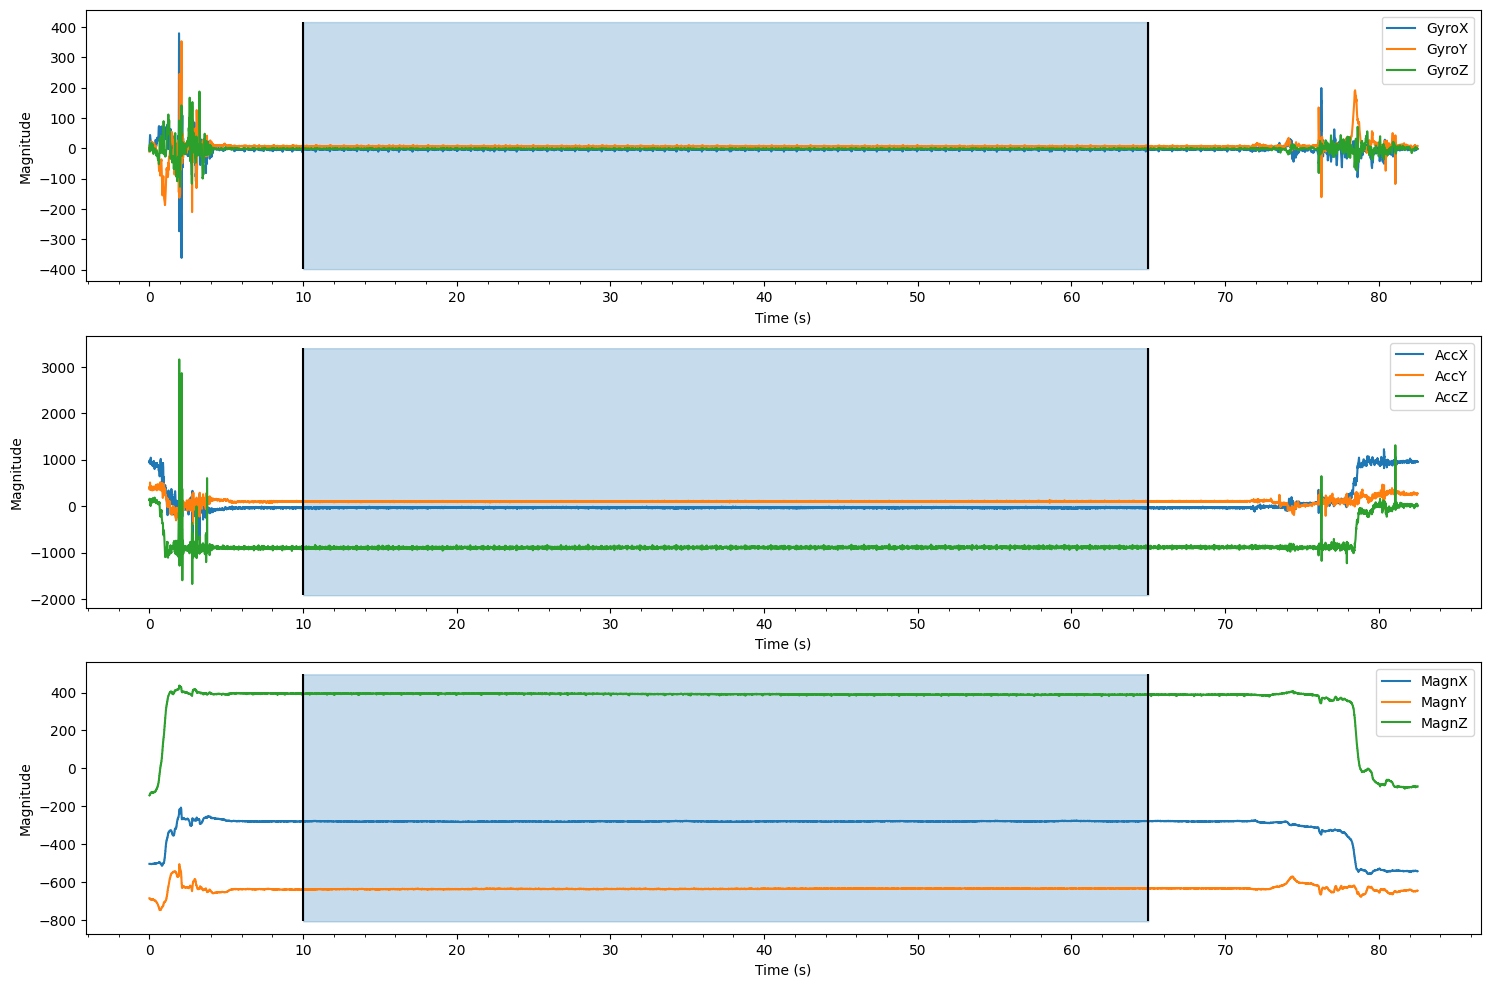

,Log Freq,Timestamp,Abs Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2000,200,1576222781,10.000,-36.191918,98.305357,-897.115495,-0.486499,7.986364,-1.527557,-278.856972,-639.776198,393.017911
2001,200,1576222781,10.005,-22.684157,97.764133,-915.007862,-0.684972,7.161936,-1.802366,-278.856972,-639.776198,393.017911
2002,200,1576222781,10.010,-31.003173,96.009994,-887.561201,-1.310926,7.284074,-1.817634,-278.021365,-637.071851,389.534964
2003,200,1576222781,10.015,-25.334931,99.274992,-884.079327,-1.295659,7.100867,-1.985573,-278.021365,-637.071851,389.534964
2004,200,1576222781,10.020,-35.980596,103.453468,-867.603353,-1.219323,7.665753,-1.710763,-278.876743,-638.857065,393.896969
...,...,...,...,...,...,...,...,...,...,...,...,...
12995,200,1576222831,64.975,-35.418961,103.538868,-885.181384,-3.921613,6.627585,-1.222214,-277.248552,-631.614362,387.814391
12996,200,1576222831,64.980,-44.203217,102.317144,-892.706502,-3.371995,6.978730,-1.237481,-277.248552,-631.614362,387.814391
12997,200,1576222831,64.985,-36.631201,102.001043,-892.711324,-3.356728,6.551249,-1.435954,-277.264842,-630.690971,389.568248
12998,200,1576222831,64.990,-28.811253,103.792989,-905.152510,-3.799476,6.902394,-1.359618,-277.264842,-630.690971,389.568248


In [104]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

labels = ["GyroX", "GyroY", "GyroZ", "AccX", "AccY", "AccZ", "MagnX", "MagnY", "MagnZ"]
Nvar = len(labels)

T1_CUT = 10
IT1_CUT = round(T1_CUT * ACQ_FREQ)
T2_CUT = 65
IT2_CUT = round(T2_CUT * ACQ_FREQ)

plt.figure(figsize=(18, 4 * (Nvar // 3)))
for i in range(Nvar // 3):
    ax = plt.subplot(Nvar // 3, 1, i + 1)
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3]], label=labels[i * 3])
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3 + 1]], label=labels[i * 3 + 1])
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3 + 2]], label=labels[i * 3 + 2])
    ymin, ymax = plt.ylim()
    plt.vlines(x=raw_data.loc[IT1_CUT, "Abs Time"], ymin=ymin, ymax=ymax, colors="black")
    plt.vlines(x=raw_data.loc[IT2_CUT, "Abs Time"], ymin=ymin, ymax=ymax, colors="black")

    ax.fill_between(raw_data.loc[IT1_CUT: IT2_CUT, "Abs Time"], ymin, ymax, color='C0', alpha=0.25)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.xlabel("Time (s)")
    plt.ylabel("Magnitude")
    plt.legend()

plt.show()
raw_data_cut = raw_data.loc[IT1_CUT: IT2_CUT - 1, :]
raw_data_cut

### 'Descrittori' Statistici

In [105]:
raw_data_cut.drop(["Log Freq", "Timestamp", "Abs Time"], axis=1).describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000
mean,-34.124336,100.654253,-892.862495,-4.319394,6.651682,-1.586719,-278.723438,-633.792049,391.294241
std,7.032836,5.225173,14.452988,1.425450,0.717922,0.364963,1.205032,1.564438,2.524105
min,-70.523078,71.834825,-959.109087,-12.242224,3.467280,-3.222214,-282.650371,-639.776198,380.808251
25%,-38.757726,97.170765,-901.407972,-4.929247,6.245906,-1.832901,-279.865783,-635.178566,389.537294
50%,-34.009900,100.809145,-893.309632,-4.394896,6.597051,-1.573359,-278.969750,-633.439856,391.293856
75%,-29.447354,104.096815,-885.124672,-3.707873,6.963463,-1.344351,-278.057426,-632.497471,393.908188
max,-8.963639,131.953547,-822.777963,2.231058,10.520715,-0.077176,-274.460483,-629.710597,396.544210


### Eventuali Histogrammi sulle statistiche o qualche bella grafichetta

### Mettiamo i dati a zero mean

In [106]:
data = (raw_data_cut[labels] - np.mean(raw_data_cut[labels], axis=0)) / np.std(raw_data_cut[labels], axis=0)
data

,GyroX,GyroY,GyroZ,AccX,AccY,AccZ,MagnX,MagnY,MagnZ
2000,2.689024,1.859174,0.162111,-0.294003,-0.449555,-0.294278,-0.110819,-3.825285,0.682914
2001,2.549783,0.710769,-0.590900,1.626755,-0.553140,-1.532304,-0.110819,-3.825285,0.682914
2002,2.110635,0.880904,-0.632737,0.443819,-0.888864,0.366812,0.582644,-2.096569,-0.697022
2003,2.121346,0.625701,-1.092911,1.249824,-0.263977,0.607734,0.582644,-2.096569,-0.697022
2004,2.174901,1.412572,-0.339898,-0.263954,0.535742,1.747756,-0.127227,-3.237742,1.031195
...,...,...,...,...,...,...,...,...,...
12995,0.279069,-0.033567,0.998791,-0.184091,0.552086,0.531479,1.223995,1.392057,-1.378710
12996,0.664662,0.455568,0.956957,-1.433183,0.318261,0.010794,1.223995,1.392057,-1.378710
12997,0.675373,-0.139901,0.413115,-0.356468,0.257762,0.010460,1.210476,1.982322,-0.683835
12998,0.364756,0.349234,0.622285,0.755502,0.600722,-0.850383,1.210476,1.982322,-0.683835


In [107]:
# mi muore il pc
# sns.pairplot(data=data[labels]);

### PCA

In [108]:
avls, avts = scipy.linalg.eig(np.cov(data.T))
sort_perm = np.flip(np.argsort(avls))

avls = np.real_if_close(avls[sort_perm])
avts = avts[:, sort_perm]

var_ratios = avls / np.sum(avls)
print('Eigenvalues:\n', np.round(avls, 4)) #todo tenere la troncatura?
print('Variability ratios:\n', np.round(var_ratios[sort_perm] * 100, 2))
print("Eigenvector:")
display(pd.DataFrame(avts))


Eigenvalues:
 [2.4787 1.7799 1.3703 0.8806 0.7382 0.5772 0.5298 0.4007 0.2455]
Variability ratios:
 [27.54 19.78 15.22  8.2   6.41  4.45  2.73  5.89  9.78]
Eigenvector:


,0,1,2,3,4,5,6,7,8
0,0.182955,0.518828,0.200849,-0.113792,-0.183332,-0.716098,-0.298487,0.087833,0.028974
1,0.124458,0.580938,-0.128269,0.036765,-0.258683,0.245043,0.638544,0.300059,-0.066930
2,0.148773,0.556457,-0.033827,0.000954,0.417444,0.480344,-0.449086,-0.241048,-0.048015
3,0.290654,-0.019698,0.645781,0.098463,-0.027320,0.012051,0.343250,-0.601734,-0.087227
4,-0.418749,0.081794,0.130727,-0.099675,-0.737496,0.289201,-0.302928,-0.186682,-0.191784
5,-0.282183,0.160784,-0.429326,0.655244,-0.001579,-0.273469,0.088880,-0.440127,-0.066760
6,-0.352749,0.120203,-0.231124,-0.708302,0.211830,-0.174513,0.273575,-0.379625,-0.108278
7,-0.460068,0.073349,0.398150,0.167303,0.345811,-0.070774,0.044294,0.325632,-0.603201
8,0.503341,-0.175856,-0.334183,-0.083919,-0.126911,-0.048942,-0.084845,-0.057864,-0.753627


In [110]:
data_rot = pd.DataFrame(data=np.dot(avts.T, data.T).T,
                        columns=[f"PC{i}" for i in range(len(avls))])

perc_soil = .85
n_comp = np.argmax(np.cumsum(var_ratios) >= perc_soil) + 1

print(f'To keep {int(perc_soil * 100)}% of our data we need {n_comp} of the {len(var_ratios)} principal components')

display(data_rot)
data_pca = data_rot[data_rot.columns[:n_comp]]
display(data_pca)


To keep 85% of our data we need 6 of the 9 principal components


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,3.076036,2.073122,-1.551800,-1.033243,-1.999176,-1.188593,0.063137,-0.097758,1.881954
1,3.746606,0.669345,0.351374,-1.672099,-1.965042,-1.400242,0.290202,-0.864625,1.925912
2,1.207550,1.271078,-0.391219,-0.540699,-0.749260,-1.870701,0.796526,-0.523908,1.866702
3,1.013899,0.946283,0.157991,-0.376801,-1.360557,-2.037401,0.945807,-1.196311,1.699956
4,1.782403,1.655788,-2.187951,0.331833,-2.574148,-1.499889,0.042188,-1.079288,0.978038
...,...,...,...,...,...,...,...,...,...
10995,-2.005359,1.306999,0.483777,-0.275306,0.887130,0.039152,-0.222978,-0.384108,-0.096118
10996,-1.998370,1.689695,-0.113766,-0.742099,0.879837,-0.077491,-0.411148,0.831053,0.072884
10997,-1.730086,0.939958,0.676641,-0.603886,0.933158,-0.570162,-0.198977,0.305088,-0.821393
10998,-1.272421,1.047091,1.676943,-1.039116,0.668939,0.220602,0.313417,0.019900,-0.978473


,PC0,PC1,PC2,PC3,PC4,PC5
0,3.076036,2.073122,-1.551800,-1.033243,-1.999176,-1.188593
1,3.746606,0.669345,0.351374,-1.672099,-1.965042,-1.400242
2,1.207550,1.271078,-0.391219,-0.540699,-0.749260,-1.870701
3,1.013899,0.946283,0.157991,-0.376801,-1.360557,-2.037401
4,1.782403,1.655788,-2.187951,0.331833,-2.574148,-1.499889
...,...,...,...,...,...,...
10995,-2.005359,1.306999,0.483777,-0.275306,0.887130,0.039152
10996,-1.998370,1.689695,-0.113766,-0.742099,0.879837,-0.077491
10997,-1.730086,0.939958,0.676641,-0.603886,0.933158,-0.570162
10998,-1.272421,1.047091,1.676943,-1.039116,0.668939,0.220602
